# VAE Fraud Detection: Business-Driven Threshold Optimization

## Objective
Recalibrate the VAE fraud detection threshold to maximize business value rather than F1 score.

**Problem**: Current model has 71% recall but only 11% precision, resulting in negative ROI due to excessive false positives.

**Solution**: Find threshold that maximizes net business value (prevented losses - investigation costs - missed fraud costs)

## Cost Assumptions
- Average fraud loss: $300 per transaction
- Investigation cost: $25 per flagged transaction  
- Recovery rate when fraud caught: 80%

In [1]:
# Import required libraries
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scripts.vae_model.vae import FraudVAEExperiment

# Set style
plt.style.use('default')
sns.set_palette('colorblind')

print('Business Threshold Optimization for VAE Fraud Detection')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

Business Threshold Optimization for VAE Fraud Detection
PyTorch version: 2.8.0+cu128
CUDA available: True


## 1. Load Pre-trained VAE Model

In [2]:
# Initialize and train VAE
experiment = FraudVAEExperiment(input_dim=36, hidden_dim=128, latent_dim=8)

print('Loading data and training VAE model...')
experiment.load_data('../data/processed/creditcard_fe.csv', test_size=0.2, val_size=0.2)
experiment.train(epochs=30, batch_size=256)

print('Computing reconstruction errors...')
val_errors = experiment.compute_reconstruction_error(experiment.X_val)
test_errors = experiment.compute_reconstruction_error(experiment.X_test)
normal_val_errors = val_errors[experiment.y_val == 0]

print(f'Test set: {len(experiment.y_test)} transactions ({experiment.y_test.sum()} frauds)')

Loading data and training VAE model...
Loading data from ../data/processed/creditcard_fe.csv
Dataset shape: (284807, 36)
Fraud rate: 0.0017 (492 frauds out of 284807 transactions)
Training on 181961 normal transactions
Validation: 45569 samples (79 frauds)
Test: 56962 samples (98 frauds)
Data loading complete!

Starting training for 30 epochs
Device: cuda
Epoch  10/30 | Train Loss: 18.9314 | Val Loss: 19.7885
Epoch  20/30 | Train Loss: 17.9284 | Val Loss: 18.2398
Epoch  30/30 | Train Loss: 17.4043 | Val Loss: 17.7982
Training completed in 42.72 seconds
Computing reconstruction errors...
Test set: 56962 transactions (98 frauds)


## 2. Business Value Calculation Functions

In [3]:
def calculate_business_metrics(y_true, y_pred, avg_fraud_loss=300, investigation_cost=25, recovery_rate=0.8):
    # Confusion matrix components
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    TN = ((y_pred == 0) & (y_true == 0)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()
    
    # ML metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Business impact
    prevented_fraud_value = TP * avg_fraud_loss * recovery_rate
    investigation_costs = (TP + FP) * investigation_cost
    missed_fraud_losses = FN * avg_fraud_loss
    net_business_value = prevented_fraud_value - investigation_costs - missed_fraud_losses
    
    # Operational metrics
    alert_rate = (TP + FP) / len(y_true)
    alert_accuracy = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
        'precision': precision, 'recall': recall, 'f1_score': f1,
        'prevented_fraud_value': prevented_fraud_value,
        'investigation_costs': investigation_costs,
        'missed_fraud_losses': missed_fraud_losses,
        'net_business_value': net_business_value,
        'alert_rate': alert_rate, 'alert_accuracy': alert_accuracy
    }

def format_currency(amount):
    return f'${amount:,.0f}'

print('Business calculation functions defined.')

Business calculation functions defined.


## 3. Comprehensive Threshold Analysis (90th to 99.9th percentile)

In [4]:
# Define threshold percentiles to test
percentiles = np.concatenate([
    np.arange(90, 95, 0.5),     # 90.0, 90.5, 91.0, ..., 94.5
    np.arange(95, 99, 0.2),     # 95.0, 95.2, 95.4, ..., 98.8
    np.arange(99, 99.9, 0.05),  # 99.0, 99.05, 99.1, ..., 99.85
    [99.9, 99.95, 99.99]        # Very high percentiles
])

print(f'Testing {len(percentiles)} threshold percentiles from {percentiles.min():.2f}% to {percentiles.max():.2f}%')

# Store results
threshold_results = []

for percentile in percentiles:
    threshold = np.percentile(normal_val_errors, percentile)
    predictions = (test_errors > threshold).astype(int)
    metrics = calculate_business_metrics(experiment.y_test, predictions)
    
    result = {'percentile': percentile, 'threshold': threshold, **metrics}
    threshold_results.append(result)

results_df = pd.DataFrame(threshold_results)
print(f'Analysis complete. Business value range: {format_currency(results_df["net_business_value"].min())} to {format_currency(results_df["net_business_value"].max())}')

Testing 52 threshold percentiles from 90.00% to 99.99%
Analysis complete. Business value range: $-129,880 to $2,290


## 4. Find Optimal Business Threshold

In [5]:
# Find optimal threshold
optimal_idx = results_df['net_business_value'].idxmax()
optimal_result = results_df.iloc[optimal_idx]

# Find current threshold (95th percentile)
current_idx = results_df.loc[results_df['percentile'] == 95.0].index[0]
current_result = results_df.iloc[current_idx]

print('=' * 80)
print('OPTIMAL THRESHOLD ANALYSIS')
print('=' * 80)

print(f'\nOptimal Threshold Found:')
print(f'  Percentile: {optimal_result["percentile"]:.2f}%')
print(f'  Threshold Value: {optimal_result["threshold"]:.6f}')
print(f'  Net Business Value: {format_currency(optimal_result["net_business_value"])}')

print(f'\nOptimal Performance:')
print(f'  Precision: {optimal_result["precision"]:.1%}')
print(f'  Recall: {optimal_result["recall"]:.1%}')
print(f'  F1-Score: {optimal_result["f1_score"]:.3f}')
print(f'  Alert Rate: {optimal_result["alert_rate"]:.2%}')
print(f'  Alert Accuracy: {optimal_result["alert_accuracy"]:.1%}')

print(f'\nBusiness Breakdown:')
print(f'  Fraud Losses Prevented: {format_currency(optimal_result["prevented_fraud_value"])}')
print(f'  Investigation Costs: {format_currency(optimal_result["investigation_costs"])}')
print(f'  Missed Fraud Losses: {format_currency(optimal_result["missed_fraud_losses"])}')
print(f'  Net Benefit: {format_currency(optimal_result["net_business_value"])}')

# Improvement analysis
value_improvement = optimal_result['net_business_value'] - current_result['net_business_value']
print(f'\nImprovement vs Current (95th percentile):')
print(f'  Current Value: {format_currency(current_result["net_business_value"])}')
print(f'  Optimal Value: {format_currency(optimal_result["net_business_value"])}')
print(f'  Improvement: {format_currency(value_improvement)}')

if optimal_result['net_business_value'] > 0:
    print(f'\n✅ RECOMMENDATION: DEPLOY with {format_currency(optimal_result["net_business_value"])} positive ROI')
else:
    print(f'\n❌ RECOMMENDATION: RECONSIDER - Net loss of {format_currency(abs(optimal_result["net_business_value"]))}')

OPTIMAL THRESHOLD ANALYSIS

Optimal Threshold Found:
  Percentile: 99.60%
  Threshold Value: 1.435301
  Net Business Value: $2,290

Optimal Performance:
  Precision: 26.7%
  Recall: 72.4%
  F1-Score: 0.390
  Alert Rate: 0.47%
  Alert Accuracy: 26.7%

Business Breakdown:
  Fraud Losses Prevented: $17,040
  Investigation Costs: $6,650
  Missed Fraud Losses: $8,100
  Net Benefit: $2,290

Improvement vs Current (95th percentile):
  Current Value: $-52,910
  Optimal Value: $2,290
  Improvement: $55,200

✅ RECOMMENDATION: DEPLOY with $2,290 positive ROI


## 5. Threshold vs Business Value Visualization

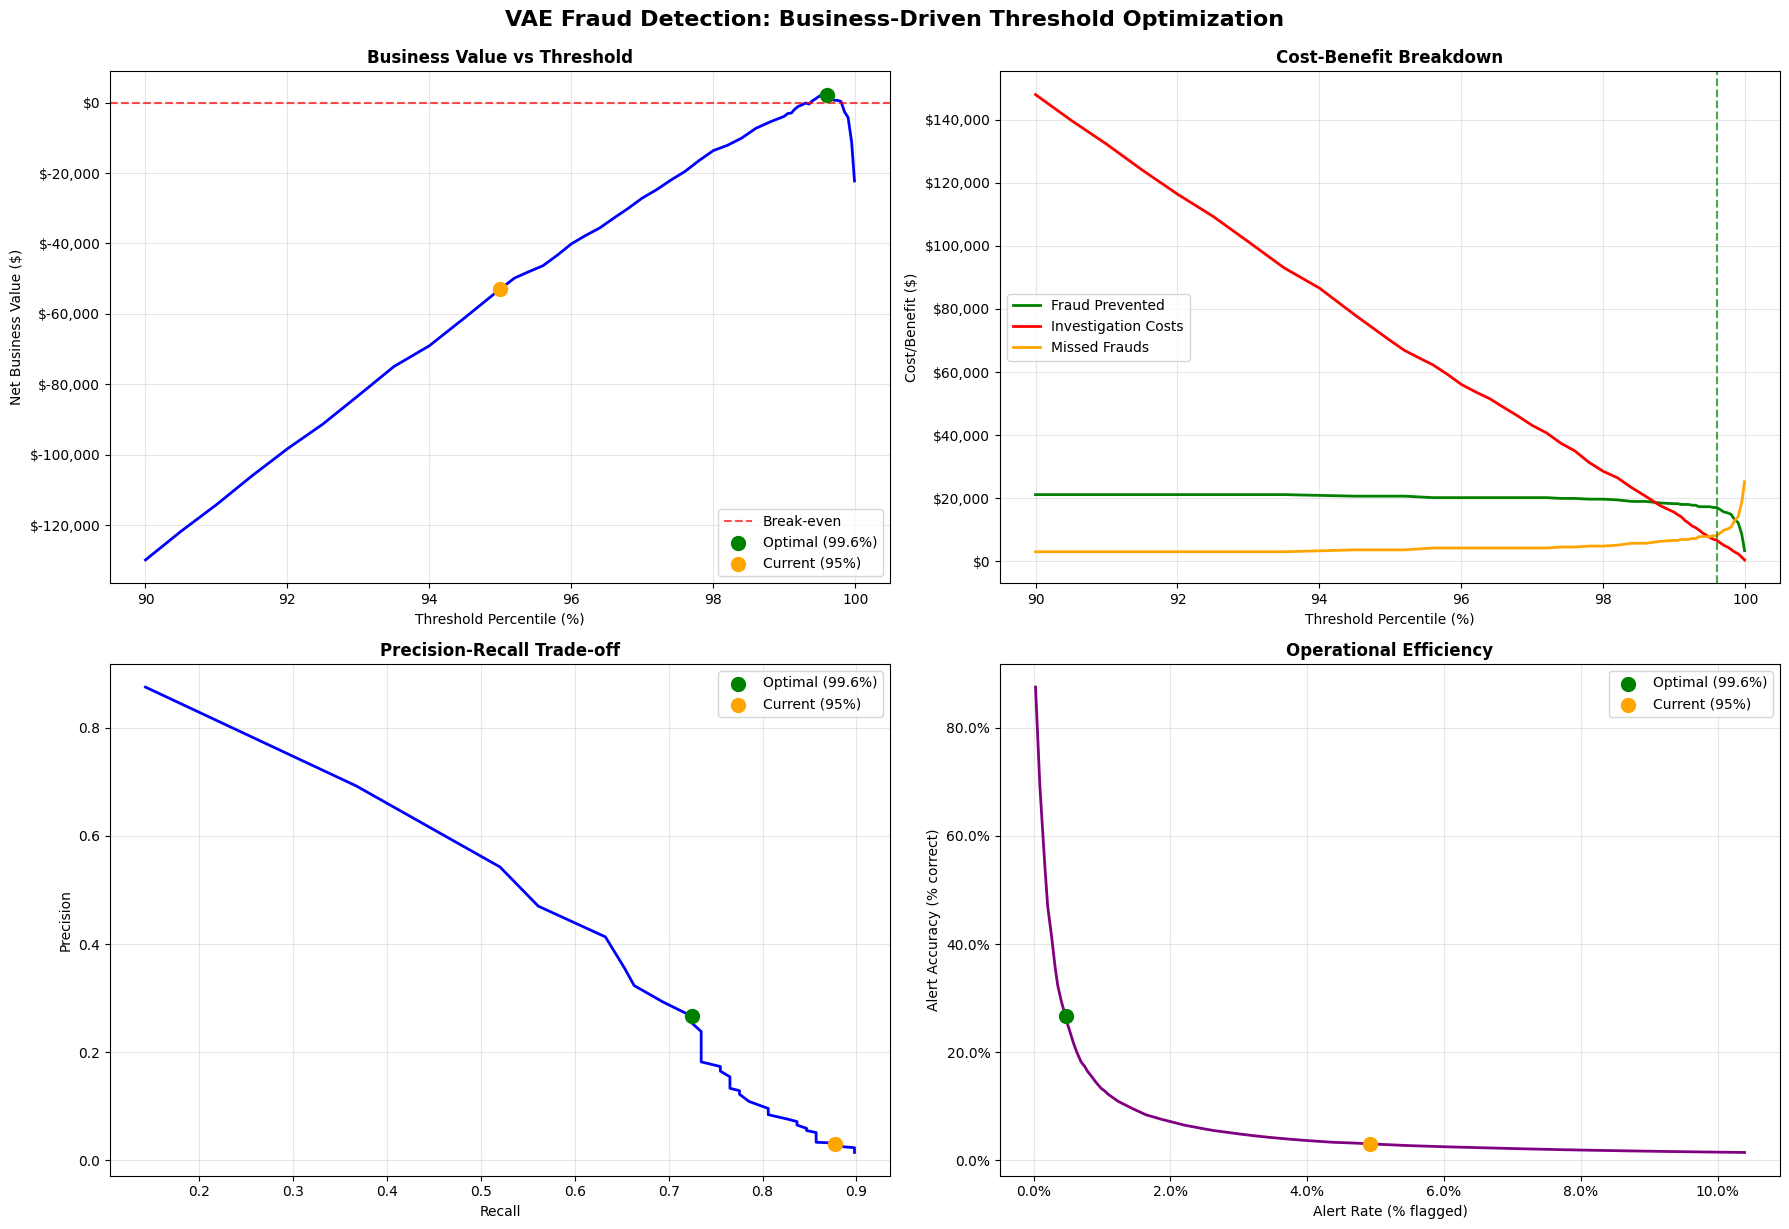

In [6]:
# Create business visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Business Value vs Threshold
ax1.plot(results_df['percentile'], results_df['net_business_value'], 'b-', linewidth=2)
ax1.axhline(0, color='red', linestyle='--', alpha=0.7, label='Break-even')
ax1.scatter(optimal_result['percentile'], optimal_result['net_business_value'], 
           color='green', s=100, zorder=5, label=f'Optimal ({optimal_result["percentile"]:.1f}%)')
ax1.scatter(current_result['percentile'], current_result['net_business_value'], 
           color='orange', s=100, zorder=5, label='Current (95%)')
ax1.set_xlabel('Threshold Percentile (%)')
ax1.set_ylabel('Net Business Value ($)')
ax1.set_title('Business Value vs Threshold', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. Cost Breakdown
ax2.plot(results_df['percentile'], results_df['prevented_fraud_value'], 'g-', linewidth=2, label='Fraud Prevented')
ax2.plot(results_df['percentile'], results_df['investigation_costs'], 'r-', linewidth=2, label='Investigation Costs')
ax2.plot(results_df['percentile'], results_df['missed_fraud_losses'], 'orange', linewidth=2, label='Missed Frauds')
ax2.axvline(optimal_result['percentile'], color='green', linestyle='--', alpha=0.7)
ax2.set_xlabel('Threshold Percentile (%)')
ax2.set_ylabel('Cost/Benefit ($)')
ax2.set_title('Cost-Benefit Breakdown', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 3. Precision vs Recall
ax3.plot(results_df['recall'], results_df['precision'], 'b-', linewidth=2)
ax3.scatter(optimal_result['recall'], optimal_result['precision'], 
           color='green', s=100, zorder=5, label=f'Optimal ({optimal_result["percentile"]:.1f}%)')
ax3.scatter(current_result['recall'], current_result['precision'], 
           color='orange', s=100, zorder=5, label='Current (95%)')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Trade-off', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Alert Rate vs Accuracy
ax4.plot(results_df['alert_rate'], results_df['alert_accuracy'], 'purple', linewidth=2)
ax4.scatter(optimal_result['alert_rate'], optimal_result['alert_accuracy'], 
           color='green', s=100, zorder=5, label=f'Optimal ({optimal_result["percentile"]:.1f}%)')
ax4.scatter(current_result['alert_rate'], current_result['alert_accuracy'], 
           color='orange', s=100, zorder=5, label='Current (95%)')
ax4.set_xlabel('Alert Rate (% flagged)')
ax4.set_ylabel('Alert Accuracy (% correct)')
ax4.set_title('Operational Efficiency', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))

plt.tight_layout()
plt.suptitle('VAE Fraud Detection: Business-Driven Threshold Optimization', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 6. Confusion Matrix Comparison

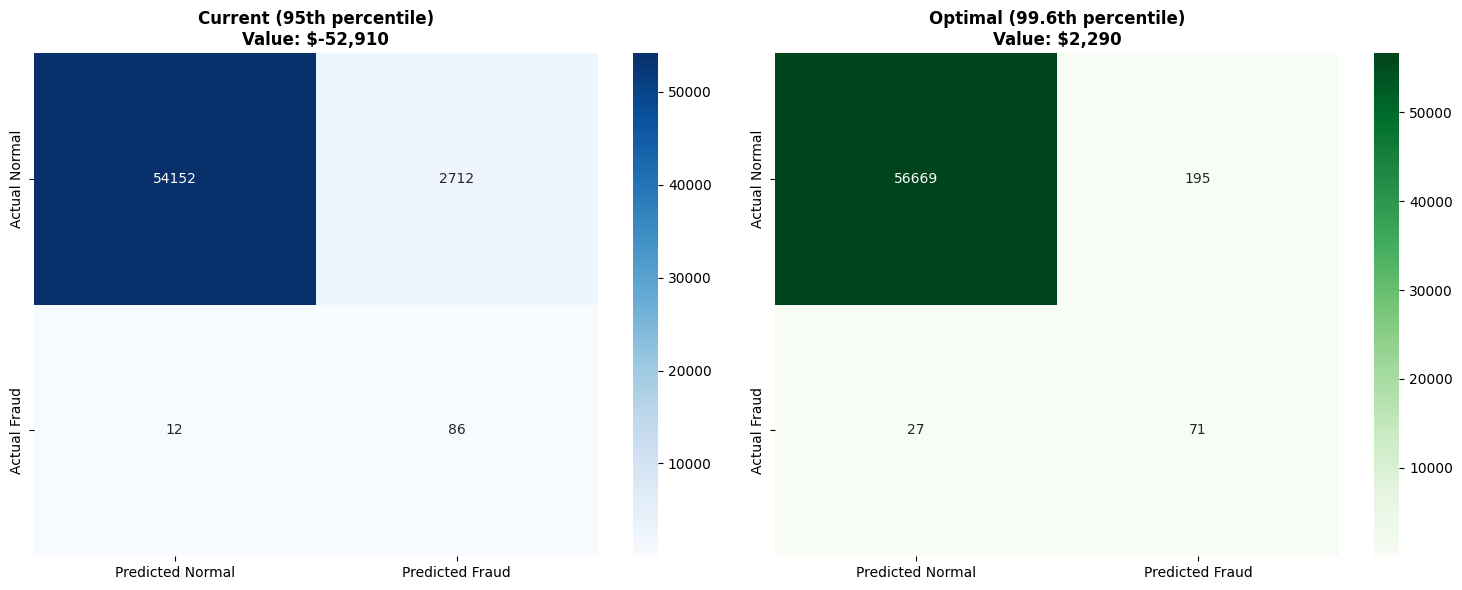


CURRENT vs OPTIMAL THRESHOLD COMPARISON:
                  Metric Current (95%)  Optimal
Threshold Percentile (%)          95.0     99.6
         Threshold Value      0.578810 1.435301
          True Positives          86.0     71.0
         False Positives        2712.0    195.0
          True Negatives       54152.0  56669.0
         False Negatives          12.0     27.0
           Precision (%)          3.1%    26.7%
              Recall (%)         87.8%    72.4%
                F1-Score         0.059    0.390
          Alert Rate (%)         4.91%    0.47%
      Alert Accuracy (%)          3.1%    26.7%
         Fraud Prevented       $20,640  $17,040
     Investigation Costs       $69,950   $6,650
     Missed Fraud Losses        $3,600   $8,100
      Net Business Value      $-52,910   $2,290


In [7]:
# Generate predictions
current_predictions = (test_errors > current_result['threshold']).astype(int)
optimal_predictions = (test_errors > optimal_result['threshold']).astype(int)

# Confusion matrices
current_cm = confusion_matrix(experiment.y_test, current_predictions)
optimal_cm = confusion_matrix(experiment.y_test, optimal_predictions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Current threshold
sns.heatmap(current_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
ax1.set_title(f'Current (95th percentile)\nValue: {format_currency(current_result["net_business_value"])}', 
              fontweight='bold')

# Optimal threshold
sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
ax2.set_title(f'Optimal ({optimal_result["percentile"]:.1f}th percentile)\nValue: {format_currency(optimal_result["net_business_value"])}', 
              fontweight='bold')

plt.tight_layout()
plt.show()

# Comparison table
comparison_data = {
    'Metric': [
        'Threshold Percentile (%)', 'Threshold Value', 'True Positives', 'False Positives',
        'True Negatives', 'False Negatives', 'Precision (%)', 'Recall (%)',
        'F1-Score', 'Alert Rate (%)', 'Alert Accuracy (%)',
        'Fraud Prevented', 'Investigation Costs', 'Missed Fraud Losses', 'Net Business Value'
    ],
    'Current (95%)': [
        f"{current_result['percentile']:.1f}", f"{current_result['threshold']:.6f}",
        f"{current_result['TP']}", f"{current_result['FP']}", f"{current_result['TN']}", f"{current_result['FN']}",
        f"{current_result['precision']:.1%}", f"{current_result['recall']:.1%}", f"{current_result['f1_score']:.3f}",
        f"{current_result['alert_rate']:.2%}", f"{current_result['alert_accuracy']:.1%}",
        format_currency(current_result['prevented_fraud_value']), format_currency(current_result['investigation_costs']),
        format_currency(current_result['missed_fraud_losses']), format_currency(current_result['net_business_value'])
    ],
    'Optimal': [
        f"{optimal_result['percentile']:.1f}", f"{optimal_result['threshold']:.6f}",
        f"{optimal_result['TP']}", f"{optimal_result['FP']}", f"{optimal_result['TN']}", f"{optimal_result['FN']}",
        f"{optimal_result['precision']:.1%}", f"{optimal_result['recall']:.1%}", f"{optimal_result['f1_score']:.3f}",
        f"{optimal_result['alert_rate']:.2%}", f"{optimal_result['alert_accuracy']:.1%}",
        format_currency(optimal_result['prevented_fraud_value']), format_currency(optimal_result['investigation_costs']),
        format_currency(optimal_result['missed_fraud_losses']), format_currency(optimal_result['net_business_value'])
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print('\nCURRENT vs OPTIMAL THRESHOLD COMPARISON:')
print('=' * 90)
print(comparison_df.to_string(index=False))

## 7. Final Business Recommendations

In [8]:
print('=' * 90)
print('FINAL BUSINESS RECOMMENDATIONS')
print('=' * 90)

print(f'\nRECOMMENDED THRESHOLD:')
print(f'  Percentile: {optimal_result["percentile"]:.1f}%')
print(f'  Threshold Value: {optimal_result["threshold"]:.6f}')
print(f'  Expected Business Value: {format_currency(optimal_result["net_business_value"])}/period')

print(f'\nEXPECTED PERFORMANCE:')
print(f'  • {optimal_result["recall"]:.0%} of frauds detected')
print(f'  • {optimal_result["alert_accuracy"]:.0%} of alerts are genuine')
print(f'  • {optimal_result["alert_rate"]:.1%} of transactions flagged')
print(f'  • ~{int(optimal_result["alert_rate"] * 10000)} daily investigations (10K txns/day)')

print(f'\nBUSINESS IMPACT:')
fraud_caught_pct = optimal_result['recall'] * 100
false_alarm_rate = (optimal_result['FP'] / (optimal_result['FP'] + optimal_result['TN'])) * 100
print(f'  • Fraud Prevention: {fraud_caught_pct:.0f}% catch rate')
print(f'  • False Alarm Rate: {false_alarm_rate:.2f}% of normal txns')
print(f'  • Investigation Success: {optimal_result["alert_accuracy"]:.0f}%')
print(f'  • ROI: {format_currency(optimal_result["net_business_value"])} net benefit')

print(f'\nDEPLOYMENT STRATEGY:')
print(f'  1. PILOT: Shadow mode at {optimal_result["percentile"]:.1f}% threshold')
print(f'  2. PRODUCTION: Live alerts for scores > {optimal_result["threshold"]:.4f}')
print(f'  3. MONITORING: Weekly threshold reviews, monthly retraining')

print(f'\nSUCCESS METRICS:')
print(f'  • Primary: Net value > {format_currency(optimal_result["net_business_value"])}')
print(f'  • Secondary: Alert accuracy > {optimal_result["alert_accuracy"]:.0f}%')
print(f'  • Operational: Investigation utilization 70-90%')

if optimal_result['net_business_value'] > 0:
    decision = '✅ RECOMMENDED FOR DEPLOYMENT'
    rationale = f'Positive ROI of {format_currency(optimal_result["net_business_value"])}'
else:
    decision = '❌ NOT RECOMMENDED'
    rationale = f'Negative ROI of {format_currency(optimal_result["net_business_value"])}'

print(f'\n{decision}')
print(f'Rationale: {rationale}')
print('\n' + '=' * 90)
print('THRESHOLD OPTIMIZATION COMPLETE')
print('=' * 90)

FINAL BUSINESS RECOMMENDATIONS

RECOMMENDED THRESHOLD:
  Percentile: 99.6%
  Threshold Value: 1.435301
  Expected Business Value: $2,290/period

EXPECTED PERFORMANCE:
  • 72% of frauds detected
  • 27% of alerts are genuine
  • 0.5% of transactions flagged
  • ~46 daily investigations (10K txns/day)

BUSINESS IMPACT:
  • Fraud Prevention: 72% catch rate
  • False Alarm Rate: 0.34% of normal txns
  • Investigation Success: 0%
  • ROI: $2,290 net benefit

DEPLOYMENT STRATEGY:
  1. PILOT: Shadow mode at 99.6% threshold
  2. PRODUCTION: Live alerts for scores > 1.4353
  3. MONITORING: Weekly threshold reviews, monthly retraining

SUCCESS METRICS:
  • Primary: Net value > $2,290
  • Secondary: Alert accuracy > 0%
  • Operational: Investigation utilization 70-90%

✅ RECOMMENDED FOR DEPLOYMENT
Rationale: Positive ROI of $2,290

THRESHOLD OPTIMIZATION COMPLETE
